# Time-Series Analysis in Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/grocery-sales-forecast-weekend-hackathon/Grocery_Sales_ParticipantsData/Sample_Submission.xlsx
/kaggle/input/grocery-sales-forecast-weekend-hackathon/Grocery_Sales_ParticipantsData/Test.csv
/kaggle/input/grocery-sales-forecast-weekend-hackathon/Grocery_Sales_ParticipantsData/Train.csv


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
train = pd.read_csv('/kaggle/input/grocery-sales-forecast-weekend-hackathon/Grocery_Sales_ParticipantsData/Train.csv')
test = pd.read_csv('/kaggle/input/grocery-sales-forecast-weekend-hackathon/Grocery_Sales_ParticipantsData/Test.csv')

In [4]:
train.head()

,Day,GrocerySales
0,1,8418.59
1,2,8447.47
2,3,8336.49
3,4,8579.17
4,5,8524.31


In [5]:
train.shape, test.shape

((692, 2), (90, 1))

In [6]:
series = train.GrocerySales.values
time = np.arange(692, dtype="float32")

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

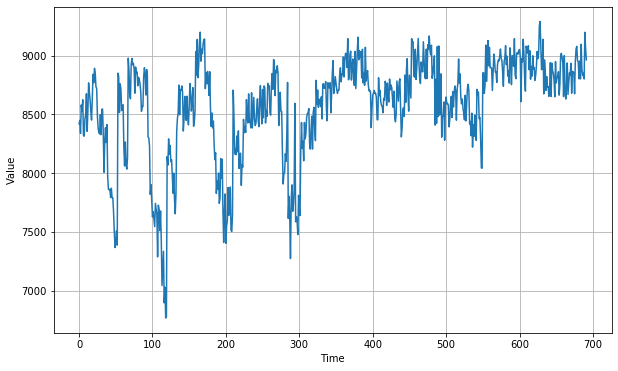

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Train-Validation Split

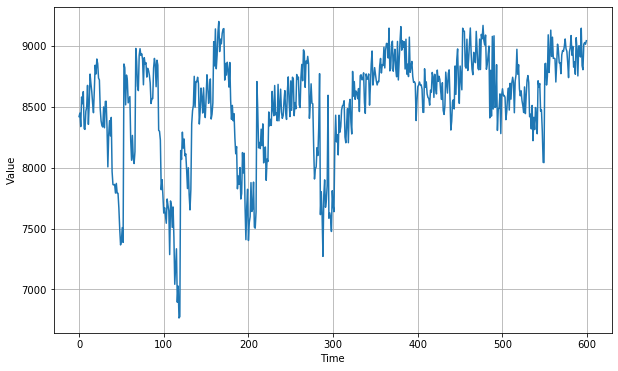

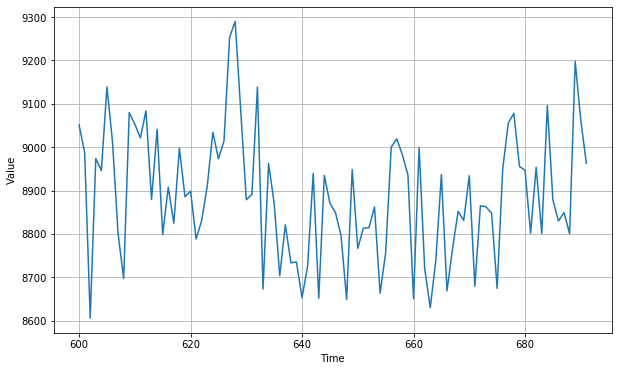

In [9]:
split_time = 600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecasting

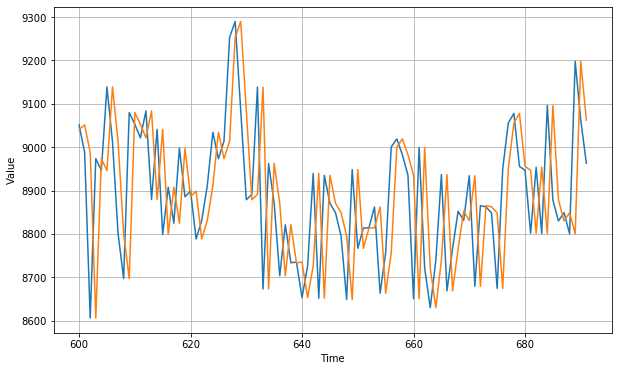

In [10]:
naive_forecast = series[split_time - 1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

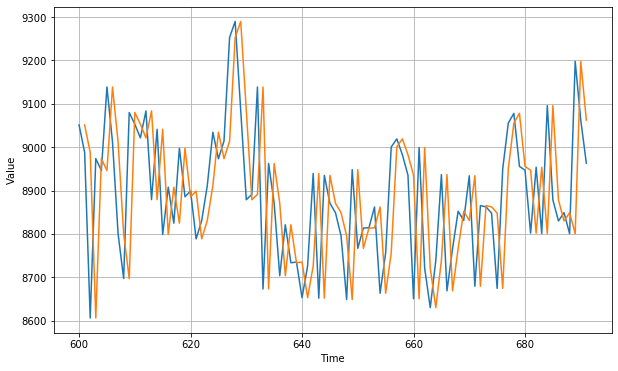

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [12]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

31439.001700845452
140.40483841295148


# Moving Average Approach

21814.868106098857
121.46384683980297


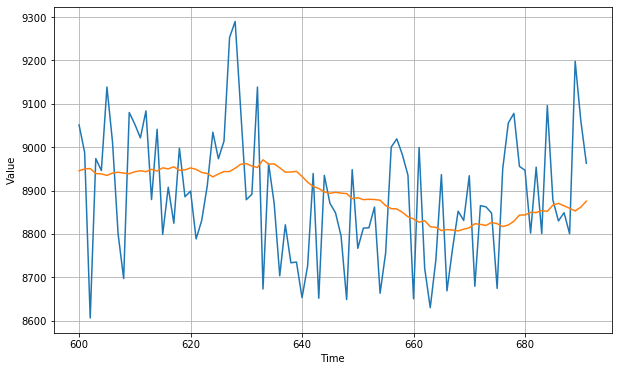

In [13]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

# Moving Average with differentiation

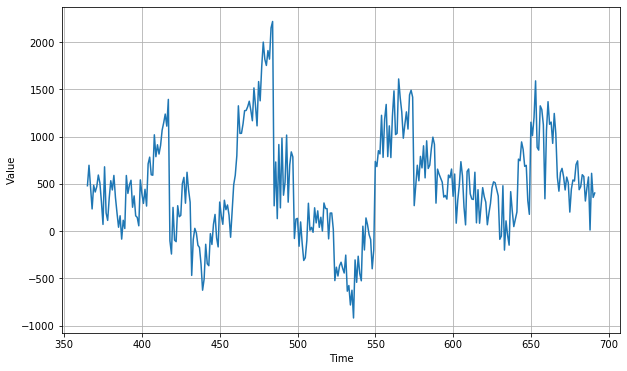

In [14]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

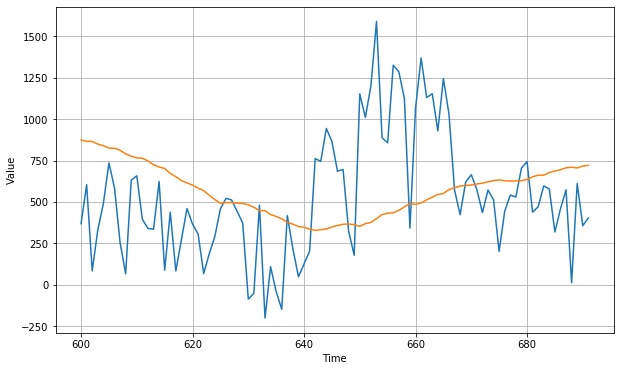

In [15]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

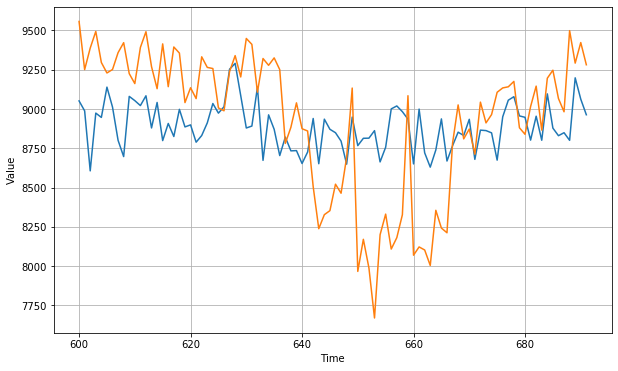

In [16]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

# Moving Average with Smooting and Differentiation

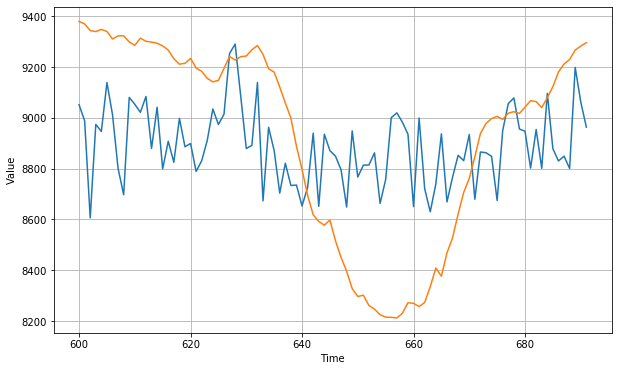

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [18]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

133029.40478303234
312.4492476973079


# Neural Network with Multiple Linear Regression

In [19]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[ 0.105715  ],
       [ 0.40711403],
       [ 0.07622942],
       [ 0.01773867],
       [-0.10837968],
       [ 0.46557286],
       [-0.390044  ],
       [-0.13122708],
       [-0.43935937],
       [ 0.3205714 ],
       [-0.5459109 ],
       [-0.4276484 ],
       [ 0.48431483],
       [-0.18849711],
       [ 0.3243417 ],
       [ 0.22681624],
       [ 0.4418593 ],
       [ 0.43994355],
       [-0.43344557],
       [ 0.35548058]], dtype=float32), array([-0.03070885], dtype=float32)]


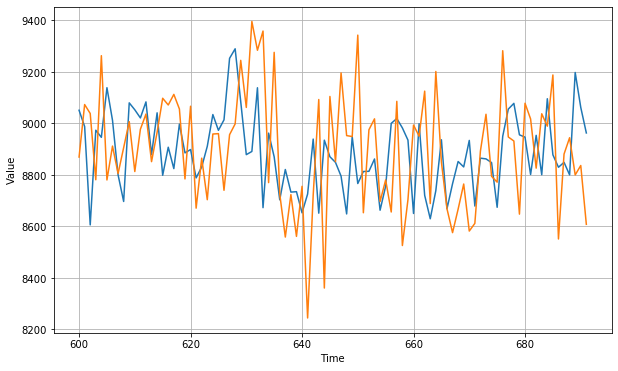

In [22]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
print(np.sqrt(keras.metrics.mean_squared_error(x_valid, results).numpy()))
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

252.56644
201.81186


# Deep Neural Network with Adam Optimizer

In [24]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(dataset,epochs=100,verbose=0)

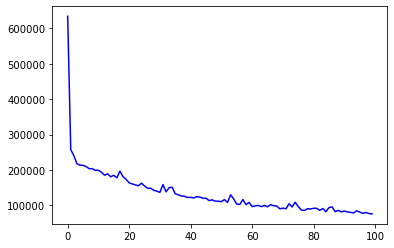

In [25]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[84258.73318965518, 81655.76939655172, 80511.79773706896, 78948.22645474138, 85031.79973060345, 81399.26619073276, 77668.37912176724, 80210.3705549569, 77377.58644935345, 76184.01212284483]


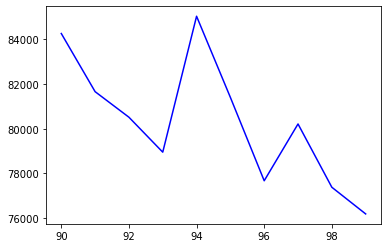

In [26]:
loss = history.history['loss']
epochs = range(90, len(loss))
plot_loss = loss[90:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

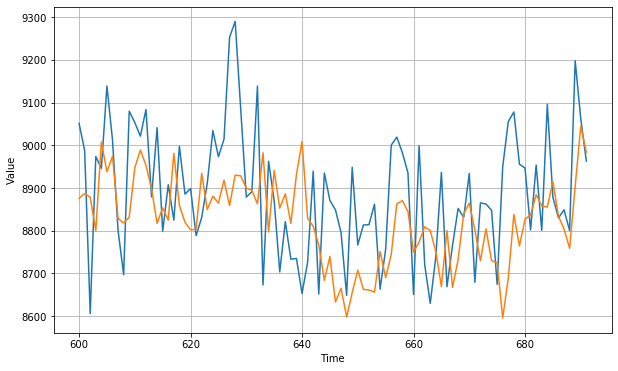

In [27]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
print(np.sqrt(keras.metrics.mean_squared_error(x_valid, results).numpy()))
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

163.8984
134.10738


Thus deep neural network thus provides the best RMSE compared to other approaches